## 6. Decision Trees and Ensemble Learning

This week, we'll talk about decision trees and tree-based ensemble algorithms

### 6.1 Credit risk scoring project

Dataset: [https://github.com/gastonstat/CreditScoring](https://github.com/gastonstat/CreditScoring)

In [1]:
import pandas as pd
import numpy as np
    
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

### 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

In [4]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv(data)

In [6]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Mapping the categorical variables back to text.

In [9]:
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

In [10]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [11]:
status_values = {
    1: 'ok', 
    2: 'default', 
    0: 'unk'
}

df.status = df.status.map(status_values)

In [12]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df_home = df.home.map(home_values)

In [13]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    6: 'unk'
}

df.marital = df.marital.map(marital_values)

In [14]:
records_values = {
    1: 'no',
    2: 'yes',
    3: 'unk'
}

df.records = df.records.map(records_values)

In [15]:
job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    5: 'unk'
}

df.job = df.job.map(job_values)

In [16]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,1,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,2,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,1,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,1,36,26,single,no,fixed,46,107,0,0,310,910


Take care of null values

In [17]:
df.describe().round()

,seniority,home,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,3.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,2.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,2.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,4.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,6.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


Note the large values for home, assets, and debt. The value 99999999 suggest that this is a placeholder for missing/null values for these columns.

In [18]:
df.income.max()

np.int64(99999999)

In [19]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [20]:
df.describe()

,seniority,home,time,age,expenses,income,assets,debt,amount,price
count,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4421.000000,4408.000000,4437.000000,4455.000000,4455.000000
mean,7.987205,2.657015,46.441751,37.077666,55.568799,130.568197,5403.433984,342.948614,1039.021773,1462.875645
std,8.173444,1.610467,14.655225,10.984856,19.515878,86.367434,11573.161523,1245.861736,474.543007,628.089913
min,0.000000,0.000000,6.000000,18.000000,35.000000,0.000000,0.000000,0.000000,100.000000,105.000000
25%,2.000000,2.000000,36.000000,28.000000,35.000000,80.000000,0.000000,0.000000,700.000000,1117.500000
50%,5.000000,2.000000,48.000000,36.000000,51.000000,120.000000,3000.000000,0.000000,1000.000000,1400.000000
75%,12.000000,4.000000,60.000000,45.000000,72.000000,165.000000,6000.000000,0.000000,1300.000000,1692.000000
max,48.000000,6.000000,72.000000,68.000000,180.000000,959.000000,300000.000000,30000.000000,5000.000000,11140.000000


In [21]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

Remove unk record and re-index

In [22]:
df = df[df.status != 'unk'].reset_index(drop=True)

Split into test/train/val data sets

In [131]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [132]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [133]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [134]:
y_test.shape

(891,)

In [26]:
del df_train['status']
del df_val['status']
del df_test['status']

### 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree
* Overfitting
* Controlling the size of a tree

In [27]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [28]:
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 2,
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [29]:
assess_risk(xi)

'ok'

In [30]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [31]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [33]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [34]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6565625681141168

In [35]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Overfitting: Memorizing the data but failing to generalize. The decision tree is too deep.

In [36]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=yes <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- amount <= 3000.00
|   |   |   |   |   |   |   |--- amount <= 1075.00
|   |   |   |   |   |   |   |   |--- age <= 38.00
|   |   |   |   |   |   |   |   |   |--- price <= 865.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- price >  865.00
|   |   |   |   |   |   |   |   |   |   |--- amount <= 862.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- amount >  862.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |--- age >  38.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- amount >  1075.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- 

In [37]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [38]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f"train: {auc}")
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"val: {auc}")

train: 0.7761016984958594
val: 0.7389079944782155


In [39]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=parttime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=parttime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



### 6.4 Decision tree learning algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [40]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [41]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


Potential threasholds

In [42]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


In [43]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [44]:
from IPython.display import display

In [45]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



Best split on assets is 3000. 

In [46]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000,'ok'],
    [5000, 1000,'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [47]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [48]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [49]:
for feature, Ts in thresholds.items():
    print('############################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('############################')

############################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

############################
############################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

############################


### 6.5 Decision trees parameter tuning

* selecting `max_depth`
* selecting `min_samples_leaf`

In [50]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761


   5 -> 0.767
   6 -> 0.750
  10 -> 0.683
  15 -> 0.659
  20 -> 0.646
None -> 0.656


values 4, 5, 6 provide th best auc score.

In [51]:
scores = []

# min_samples - the minimum number of examples to have at each leaf node.
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [52]:
columns = ['max_depth', 'min_sample_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_sample_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


In [53]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_sample_leaf,auc
22,6,15,0.784387
21,6,10,0.778977
24,6,100,0.776434
14,5,20,0.774028
23,6,20,0.773337


In [54]:
df_scores_pivot = df_scores.pivot(index='min_sample_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth            4      5      6
min_sample_leaf                     
1                0.761  0.766  0.751
2                0.761  0.766  0.757
5                0.761  0.768  0.760
10               0.761  0.764  0.779
15               0.764  0.770  0.784
20               0.761  0.774  0.773
100              0.756  0.763  0.776
200              0.747  0.759  0.768
500              0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_sample_leaf'>

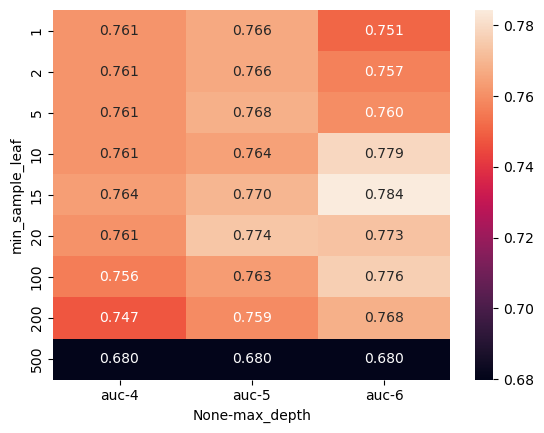

In [55]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [56]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 6.6 Ensembles and random forest

* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [59]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [60]:
roc_auc_score(y_val, y_pred)

0.7918281223511177

In [61]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [62]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

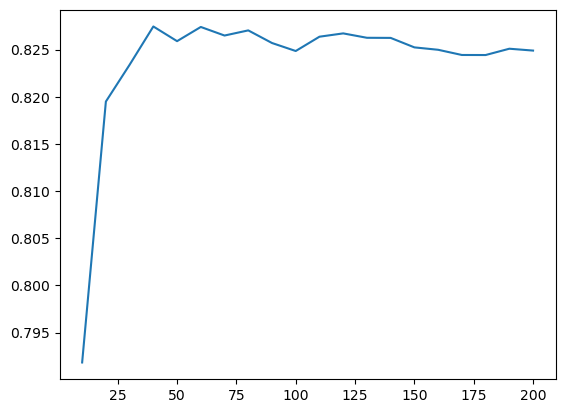

In [63]:
plt.plot(df_scores.n_estimators, df_scores.auc)

Tune max_depth parameter

In [64]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth= d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [65]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.781699
1,5,20,0.795137
2,5,30,0.799272
3,5,40,0.803501
4,5,50,0.806492


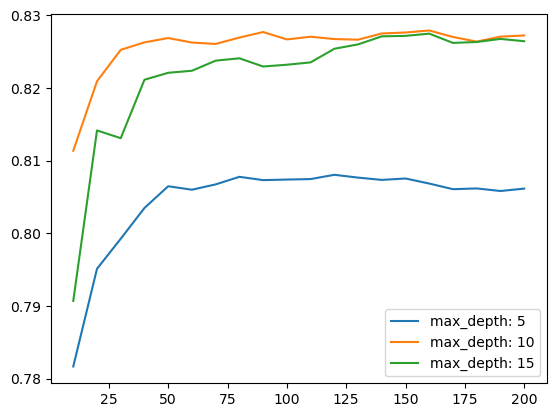

In [66]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth: %d' % d)

plt.legend()

In [67]:
max_depth = 10

In [68]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [69]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.811372
1,1,20,0.820933
2,1,30,0.825256
3,1,40,0.826285
4,1,50,0.826878


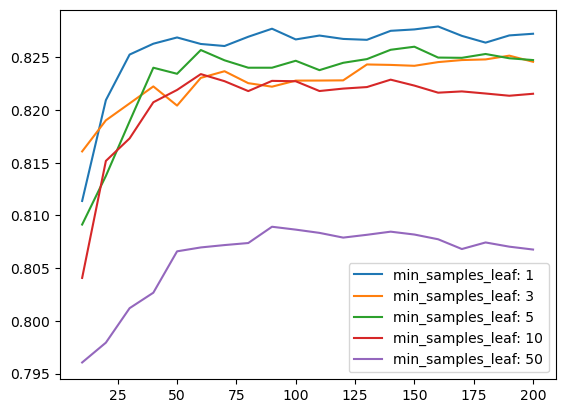

In [70]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_samples_leaf: %d' % s)

plt.legend()

In [71]:
min_samples_leaf = 1 # video used 3

In [72]:
rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Other useful parametes:

* `max_features`
* `bootstrap`

[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### 6.7 Gradient boosting and XGBoost

* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

In [73]:
!pip install xgboost

In [74]:
import xgboost as xgb

In [75]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [76]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [77]:
y_pred = model.predict(dval)

In [78]:
roc_auc_score(y_val, y_pred)

0.8168154077159673

In [79]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [80]:
%%capture output 
# save output from cell in an object

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, 
                  evals=watchlist)

In [81]:
s = output.stdout

In [82]:
line = s.split('\n')[0]
line

'[0]\ttrain-auc:0.86649\tval-auc:0.77922'

In [83]:
num_iter, train_auc, val_auc = line.split('\t')
num_iter, train_auc, val_auc

('[0]', 'train-auc:0.86649', 'val-auc:0.77922')

In [84]:
int(num_iter.strip('[]'))

0

In [85]:
float(train_auc.split(':')[1])

0.86649

In [86]:
float(val_auc.split(':')[1])

0.77922

In [87]:
def parse_xgb_output(outuput):
    results = []

    for line in outuput.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_itr', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [88]:
df_score = parse_xgb_output(output)

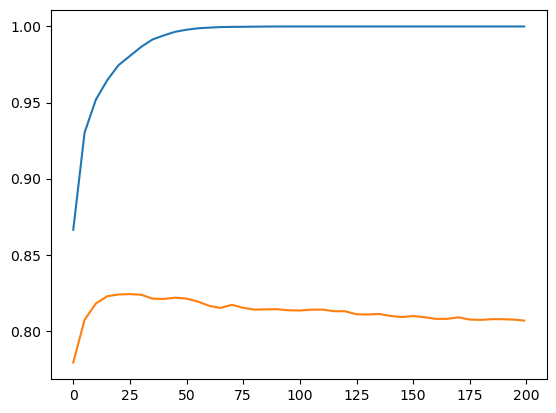

In [89]:
plt.plot(df_score.num_itr, df_score.train_auc, label='train')
plt.plot(df_score.num_itr, df_score.val_auc, label='val')

### 6.8 XGBoost parameter tuning

Tuning the following parameters:

* `eta` Learning Rate
* `max_depth`
* `min_child_weight` min_samples_leaf in RL

Tune eta

In [90]:
scores = {}

In [91]:
%%capture output 
# save output from cell in an object

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, 
                  evals=watchlist)

In [92]:
key = 'eta=%s' % (xgb_params['eta'])

In [93]:
scores[key] = parse_xgb_output(output)
scores['eta=0.01']

,num_itr,train_auc,val_auc
0,0,0.86649,0.77922
1,5,0.87021,0.77813
2,10,0.87174,0.77855
3,15,0.87402,0.78412
4,20,0.87636,0.78718
5,25,0.88604,0.79488
6,30,0.89297,0.79911
7,35,0.89642,0.79961
8,40,0.89861,0.79880
9,45,0.90054,0.79699


In [94]:
scores.keys()

dict_keys(['eta=0.01'])

In [95]:
etas = ['eta=1.0', 'eta=0.3', 'eta=0.1']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_itr, df_score.val_auc, label=eta)

plt.legend()

KeyError: 'eta=1.0'

In [ ]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_itr, df_score.val_auc, label=eta)

plt.legend()

KeyError: 'eta=0.3'

eta = 0.1 is the best

Tune max_depth

In [ ]:
scores = {}

In [ ]:
%%capture output 
# save output from cell in an object

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, 
                  evals=watchlist)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_itr, df_score.val_auc, label=max_depth)
plt.legend()

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_itr, df_score.val_auc, label=max_depth)
plt.ylim(0.8, 0.84)
plt.legend()

max_depth=3

In [ ]:
scores={}

In [ ]:
%%capture output 
# save output from cell in an object

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, 
                  evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_itr, df_score.val_auc, label=min_child_weight)
plt.legend()

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_itr, df_score.val_auc, label=max_depth)
plt.ylim(0.82, 0.84)
plt.legend()

min_child_weight=1 (default)

In [ ]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

### 6.9 Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [96]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [97]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7846110532561574

In [98]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [99]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8245713351577826

In [100]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [101]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8337379816424887

In [102]:
df_full_train = df_full_train.reset_index(drop=True)

In [105]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [106]:
del df_full_train['status']

In [107]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.fit_transform(dicts_full_train)

In [113]:
feature_names = dv.get_feature_names_out()

In [117]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [118]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [120]:
y_pred = model.predict(dtest)
y_pred[:10]

array([0.03446261, 0.58627343, 0.11050353, 0.02399598, 0.01815259,
       0.94756776, 0.13045265, 0.53854024, 0.5648203 , 0.5260916 ],
      dtype=float32)

In [128]:
y_pred.shape, y_test.shape, y_full_train.shape

((3563,), (891,), (3563,))

In [129]:
roc_auc_score(y_full_train, y_pred)

0.9223958577936413

### 6.10 Summary

* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.



### 6.11 Explore more

* For this dataset we didn't do `EDA` or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
* There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
* XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.